In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime

import matplotlib.dates as mdates
import vtk
import math
import sys
from volsung.volsungmodel import *

In [17]:
model=VolsungModel('Results.sigurd')
zoneId=1
wellnames=model.flowNetwork.portObjects
z=-125

AttributeError: 'NoneType' object has no attribute 'plotWellTrackFieldData'

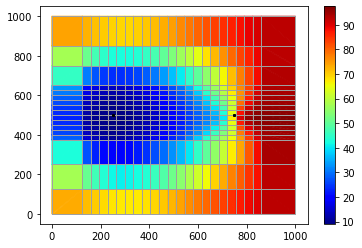

In [43]:
f = plt.figure()
ax = plt.subplot(111)                                       # last zone
model.reservoir.slicePlot(f, ax, z, zoneId, arrname = "Temperature", offset = -273.15)
#now print the welltracks onto the plot
model.flowNetwork.plotWellTracks(f,ax,linewidth=2,color='#000000',fontsize=0)
for wellname in wellnames:
    well=model.flowNetwork.portObject(wellname)
    well.plotWellTrackFieldData(f,ax,z,float('nan'),"Temperature",offset=-273.15,radius=20,fontsize=0,labeloffset=(50,50))
ax.axis('equal')    # set aspect ratio to equal
plt.xticks(rotation=30)
plt.show()
plt.close()

In [42]:
for wellname in wellnames:
    monitor=model.flowNetwork.portObject(wellname)
    kernel=vtk.vtkShepardKernel()
    kernel.SetNumberOfPoints(6)
    kernel.SetKernelFootprintToNClosest()
    interp=model.reservoir.interpolateWellTrack(monitor.WellGridGeometry[zoneId],zoneId,kernel=kernel)
    probe=model.reservior.probleWellTrack(monitor.WellGridGeometry[zoneId],zoneId,average=False)
    ##plot the field data by requiring a time slice.
    #if time is nan then all data is returned; else data closest to the time provided is chosen
    fielddata=monitor.reservoir1DFieldData.timeSlice(time=float('nan'))
    plt.figure()
    plt.plot(probe["Temperature"] - 273.15, probe["z"], '--b')
    plt.plot(fielddata["Temperature"] - 273.15, fielddata["z"], "-r")
    plt.xlim(0,350)
    plt.ylabel("z [m]")
    plt.xlabel("Temperature [C]")
    plt.legend(['Model (Interp)','Model (block)', 'Measured'])
    plt.title(wellname + ' temperature')
    plt.show()
    plt.close()

AttributeError: 'NoneType' object has no attribute 'WellGridGeometry'

In [44]:
#plot well enthalpy over time
for well in model.flowNetwork.portObjects:
    if (well.outputPorts[0].fieldHistory("Enthalpy").size==0):
        print(well.name+" has no enthalpy data")
    elif (math.isnan(well.outputPorts[0].fieldHistory("Time")[0])):
        print(well.name+" has nan in enthalpy data")
    else:
        f=plt.figure()
        ax=plt.subplot(111)
        h=well.outputPorts[0].zoneHistory("Enthalpy")/1e3
        ax.plot(model.reservoir.toDateTime(model.reservoir.zoneTimes()),h,"o-b")
        ax.plot(model.reservoir.toDateTime(well.outputPorts[0].fieldHistory("Time")),well.outputPorts[0].fieldHistory("Enthalpy")/1e3,"or")
        plt.ylabel("H [kJ/kg]")
        plt.title(wellname)
        plt.legend(['Model','Data'],loc='best')
        plt.show()
        plt.close()

InjectionWell has no enthalpy data
ProductionWell has no enthalpy data


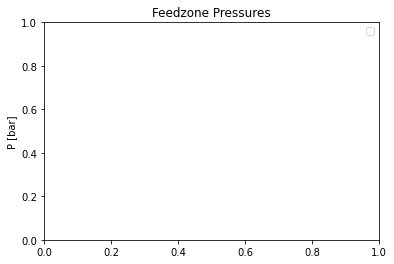

In [45]:
#plot well feedzone pressure over time
f=plt.figure()
ax=plt.subplot(111)
leg=[]
for well in model.flowNetwork.portObjects:
    if well.name in wellnames:
        t=model.reservoir.toDateTime(model.reservoir.zoneTimes())
        numzones=len(t)
        fzpressure=[]
        for i in range(0,len(t)):
            fzpressure.append(well.feedzoneData(i,'Reservoir Pressure')/1e5)
        ax.plot(t,fzpressure, "o-")
        elev=well.feedzoneData(0,'Elevation')[0]
        leg.append(well.name+' at '+str(elev)+'m')
ax.set_ylabel("P [bar]")
plt.title('Feedzone Pressures')
plt.legend(leg)
plt.show()
plt.close()